<a href="https://colab.research.google.com/github/fresa-yz/BA765-Session02/blob/master/Assignment_1_Ying_Zhang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment #1 -Ying Zhang.ipynb**

The goal of this notebook is to show the possibilities of predicting financial outcomes from textual data via DistilBERT transformer model. 

This notebook builds on the next files: 

*   `company_des.csv` with company descriptions, see `2. Business Descriptions.ipynb` 
*   `ta.csv` and `rev.csv` with total assets and revenue data, see `3. YFinance Data.ipynb`

The steps this ipynb goes through are below: 

1.   Mount your Google Drive and establish the working directory. 
2.   Install and load the necessary libraries. 
3.   Load, merge, clean the data. 
4.   Create the label variable. 
5.   Prepare the predictor.  
6.   Run the DistilBERT model. 
7.   Train logistic regression and evaluate its accuracy.





**Note**. Save this Colab notebook to your Drive via File > Save a copy in Drive to be able to edit it. 

# 1. Mount your Google Drive and establish the working directory

Mounting allows to access files on your Google Drive. You'll need to allow the Google Drive for desktop's access to your Google Account and copying the sign in code into the authorization code field. 

In [158]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Set working directory to a Google Drive folder: change the `root_dir` to the folder on your Google Drive. 

`root_dir = "/content/gdrive/MyDrive/...`

In [159]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/gdrive/My Drive/financial_analytics/lecture02/"

# choose where you want your project files to be saved
project_folder = "CSV/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/gdrive/My Drive/financial_analytics/lecture02/CSV/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


Check if the function worked by listing the files in the project folder. During the very first run it should contain only `new_file_in_working_directory.txt`. If you upload other files to your `project_folder`, other files will be listed too. 

In [160]:
!ls

 assign1.csv			    'Russell 3000 tickers.csv'	 ta.csv
 new_file_in_working_directory.txt  'stock_des (1).csv'		 tickers.csv
 rev.csv			     stock_des.csv


Please upload the necessary files (`stock_des.csv`, `ta.csv`, `rev.csv`) in your `project_folder` folder. 

You can upload the files in your Google Drive `project_folder` via drive.google.com or via below `files.upload()` button. 

In [161]:
# # Upload data
# from google.colab import files
# uploaded = files.upload()

# 2. Install, load the libraries

In [162]:
!pip install transformers

In [163]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# 2. STAGE1: Load, merge, clean the data

In [164]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
ta = pd.read_csv('ta.csv')
rev = pd.read_csv('rev.csv')

In [165]:
# clean up the column names 
ta.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
rev.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)

In [166]:
# merge the dataframes into one
df = pd.merge(ta, rev, on='ticker')
df = pd.merge(df, stock_des, on='ticker')

In [167]:
# remove the observations with ta and rev less than 10000 
print(df.shape)
df = df[(df['Total Assets'] >= 10000) & (df['Total Revenue'] >= 10000)]
print(df.shape)

(2830, 4)
(2719, 4)


count     2719.000000
mean        22.795845
std        386.905317
min          0.134677
25%          1.242993
50%          2.239040
75%          7.051726
max      18819.875000
Name: ar_ratio, dtype: float64


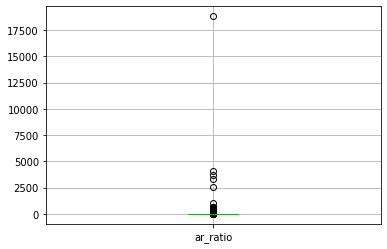

In [168]:
# create the assets to revenue ratio 
df['ar_ratio'] = df['Total Assets']/df['Total Revenue']
print(df['ar_ratio'].describe())
df.boxplot(column='ar_ratio');

We have 6 outliers with the ratio of 1000+. Let's remove them. 

In [169]:
df = df[df['ar_ratio']<1000]
print(df.shape)

(2713, 5)


Due to Colab's RAM limitations, limit the description size. We allow 350 characters, which is approximately 50 words and 3+ sentences. In case if you still face RAM issues try terminating other Colab notebooks (Runtime > Manage sessions) or reducing the characters to 300. 

In [170]:
df['description'] = df['description'].str.slice(0,350)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Create a binary variable that is 1 if the assets to revenue ratio is above its median and 0 otherwise. 

This is the **dependent variable** (label) that we'll try to predict. 

In [171]:
df['HIGH_ARR'] = (df['ar_ratio'].gt(df['ar_ratio'].median())).astype(int)

In [172]:
df.sample(5)

,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR
2732,WINA,3.134320e+07,6.606180e+07,Winmark Corporation operates as a franchisor o...,0.474453,0
876,ERII,2.043140e+08,1.189860e+08,"Energy Recovery, Inc., together with its subsi...",1.717126,0
545,CLAR,2.806910e+08,2.240070e+08,Clarus Corporation focuses on the outdoor and ...,1.253046,0
2386,STAY,4.089149e+09,1.027455e+09,"Extended Stay America, Inc., together with its...",3.979881,1
1795,NTB,1.473863e+10,4.941890e+08,The Bank of N.T. Butterfield &amp; Son Limited...,29.823881,1


In [173]:
df.shape

(2713, 6)

# Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator. 

Load a pre-trained BERT model.

In [174]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokenize the textual data for DistilBERT. 

In [175]:
tokenized = df['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size. 

In [176]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [177]:
np.array(padded).shape

(2713, 109)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [178]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2713, 109)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [179]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Logistic regression model 



Keep the first layer of the hidden states and assign the outcome variable to `labels`. 

In [180]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [181]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.8379970544918999


Check if this approach works better than a random guess (0.8 > 0.5). 

In [182]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.512 (+/- 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


#Confusion Matrix("HIGH_ARR")

In [183]:
y_pred=lr_clf.predict(test_features)

1. print the confusion matrix in the form of the array object

In [184]:
#1. print the confusion matrix in the form of the array object

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_pred, test_labels)
cnf_matrix


array([[286,  60],
       [ 50, 283]])

2.visualizing confusion matrix using heatmap

Text(0.5, 257.44, 'Predicted label')

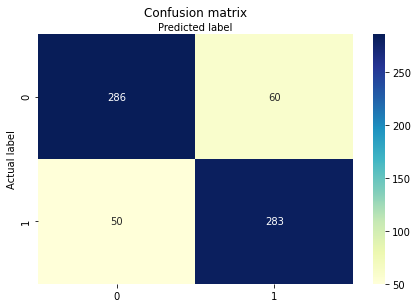

In [185]:
#2.visualizing confusion matrix using heatmap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

3.Check evaluation Metrics

In [221]:
#Look at the True Postive and True Negative:
TP = 283
TN = 286

# Look at the False Postive and False Negative

FP = 60
FN = 50

In [228]:
#Evaluation Metrics

print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred))
print("Recall:",metrics.recall_score(test_labels, y_pred))
print("Specificity:", TN/(TN+FP))

Accuracy: 0.8379970544918999
Precision: 0.8498498498498499
Recall: 0.8250728862973761
Specificity: 0.8265895953757225


#Interpretation of the confusion matrix(HIGH_ARR) :

The DistilBERT model has succesfully predicted 286 companies with high asset intesity and 286 companies with low asset intensity based on the business descriptions. And the model fails to identify the other 60 high asset intensity companies, and wrongly classified 50 low-asset-indensity companies to the "high asset intensity" group.

================================================================

Overall, the DistilBERT model performs very well. During our evaluation with the test data, the model correctly predict whether the company belongs to the "high asset intensity group" 84% of the time. 

* (Precision)
The model correctly predicted 85% of the "high-asset intensity" companies out of all the predictive "high asset intensity" classes.

* (Recall)
The model correctly predicted 82% of the "high-asset intensity" companies Out of all the true"high-asset intensity"companies.

* (Specificity)
The model correctly predicted 83% of the "low-asset intensity" companies out of all the true " low-asset intensity"companies.

Thus, the model seems to perform quite well for both classifying both "high or low" asset intensity companies. 


#STAGE 2: Predict R&D intensity

In [187]:
data = pd.read_csv("assign1.csv")

In [188]:
data.shape

(2684, 3)

All the observations with sales less than or equal zero has been removed in the "assign1.csv" file.

In [189]:
print(data.head())
data.sale.describe()

    tic       sale     xrd
0   AAL  17337.000     NaN
1  CECE    316.011     NaN
2   PNW   3586.982     NaN
3   PRG   2484.595     NaN
4   ABT  34608.000  2420.0


count      2684.000000
mean       5739.450425
std       22254.520184
min           0.024000
25%         277.027000
50%         964.943500
75%        3242.988000
max      556933.000000
Name: sale, dtype: float64

First, "NaN" in the xrd column should be coded as 0

In [190]:
data['xrd']= data['xrd'].fillna(0)
print(data.head())
data.info()

    tic       sale     xrd
0   AAL  17337.000     0.0
1  CECE    316.011     0.0
2   PNW   3586.982     0.0
3   PRG   2484.595     0.0
4   ABT  34608.000  2420.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684 entries, 0 to 2683
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tic     2684 non-null   object 
 1   sale    2684 non-null   float64
 2   xrd     2684 non-null   float64
dtypes: float64(2), object(1)
memory usage: 63.0+ KB


Next, create a new variable called"RD_intensity"which equals XDR/SALE.

In [191]:
data['RD_intensity']= data['xrd']/data['sale']
data.head()

,tic,sale,xrd,RD_intensity
0,AAL,17337.000,0.0,0.000000
1,CECE,316.011,0.0,0.000000
2,PNW,3586.982,0.0,0.000000
3,PRG,2484.595,0.0,0.000000
4,ABT,34608.000,2420.0,0.069926


Inspect the variable"RD_intensity". The statistics seem reasonable, so we move on to create "HIGH_INNOVATION"variable".



count    2684.000000
mean        3.796761
std        90.496557
min         0.000000
25%         0.000000
50%         0.000000
75%         0.064922
max      4299.125000
Name: RD_intensity, dtype: float64


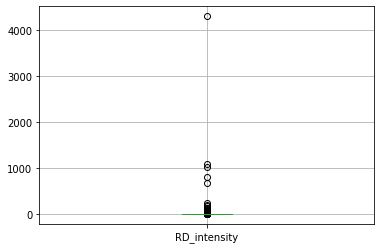

In [192]:
print(data['RD_intensity'].describe())
data.boxplot(column='RD_intensity');

After inspecting the outliers, the numbers seem reasonable.

In [193]:
data[data['RD_intensity']==4299.125000]

,tic,sale,xrd,RD_intensity
1695,BEAM,0.024,103.179,4299.125


In [194]:
data[data['RD_intensity']!=4299.125000]['RD_intensity'].describe()

count    2683.000000
mean        2.195819
std        36.207454
min         0.000000
25%         0.000000
50%         0.000000
75%         0.064485
max      1091.421053
Name: RD_intensity, dtype: float64

**Create a new label variable "HIGH_INNOVATION".**

"HIGH_INNOVATION" equals 1 if the company's R&D spending is above the median value(zero, in this case). 

"HIGH_INNOVATION" equals 0 if the company's R&D spending is not above the median value(zero, in this case). 


In [195]:
data['HIGH_INNOVATION']= (data['RD_intensity'].gt(data['RD_intensity'].median())).astype(int)


In [196]:
#Have a look at the data
print(data.head())

print(data.describe())

    tic       sale     xrd  RD_intensity  HIGH_INNOVATION
0   AAL  17337.000     0.0      0.000000                0
1  CECE    316.011     0.0      0.000000                0
2   PNW   3586.982     0.0      0.000000                0
3   PRG   2484.595     0.0      0.000000                0
4   ABT  34608.000  2420.0      0.069926                1
                sale           xrd  RD_intensity  HIGH_INNOVATION
count    2684.000000   2684.000000   2684.000000      2684.000000
mean     5739.450425    184.456412      3.796761         0.424739
std     22254.520184   1423.600794     90.496557         0.494395
min         0.024000      0.000000      0.000000         0.000000
25%       277.027000      0.000000      0.000000         0.000000
50%       964.943500      0.000000      0.000000         0.000000
75%      3242.988000     48.233000      0.064922         1.000000
max    556933.000000  42740.000000   4299.125000         1.000000


#Train the distilBERT model to predict "HIGH_INNOVATION"

Before training the distilBERT model, we need to merge the dataframe with "HIGH_INNOVATION" variable and the dataframe with "HIGH_ARR"variable using "TICKER” information. 

The dataframe variable "df_des" is created. It contains "business descriptions",  "HIGH_ARR", and "HIGH_INNOVATION" , which are the variables we need to perform futher analysis.

In [197]:
df_des = pd.merge(data,df,left_on='tic',right_on='ticker')

In [198]:
df_des.head()


,tic,sale,xrd,RD_intensity,HIGH_INNOVATION,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR
0,AAL,17337.000,0.0,0.000000,0,AAL,6.200800e+10,1.733700e+10,"American Airlines Group Inc., through its subs...",3.576628,1
1,CECE,316.011,0.0,0.000000,0,CECE,4.193140e+08,3.160110e+08,CECO Environmental Corp. provides industrial a...,1.326897,0
2,PNW,3586.982,0.0,0.000000,0,PNW,2.002042e+10,3.586982e+09,"Pinnacle West Capital Corporation, through its...",5.581411,1
3,PRG,2484.595,0.0,0.000000,0,PRG,1.317404e+09,2.484595e+09,"PROG Holdings, Inc. operates as an omnichannel...",0.530229,0
4,ABT,34608.000,2420.0,0.069926,1,ABT,7.254800e+10,3.460800e+10,"Abbott Laboratories discovers, develops, manuf...",2.096278,0


In [199]:
df_des.shape

(2639, 11)

Tokenize the textual data for DistilBERT.

In [201]:
tokenized = df_des['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [202]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded_RD = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [203]:
attention_mask = np.where(padded_RD  != 0, 1, 0)
attention_mask.shape

(2639, 109)

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable. 

In [204]:
input_ids_RD = torch.tensor(padded_RD)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids_RD, attention_mask=attention_mask)

# Logistic regression model 

Assign the" HIGH_INNOVATION" as the outcome variable

In [205]:
features_both = last_hidden_states[0][:,0,:].numpy()
labels_RD = df_des['HIGH_INNOVATION']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set. 

In [206]:
train_features_both, test_features_both, train_labels_RD, test_labels_RD = train_test_split(features_both, labels_RD)
clf = LogisticRegression(max_iter=5000)
clf.fit(train_features_both, train_labels_RD)
print(clf.score(test_features_both, test_labels_RD))

0.9045454545454545


In [207]:
y_pred_RD=clf.predict(test_features_both)

#Model evalution("HIGH_INNOVATION")

the re-trained DistilBERT model has an accuracy score of about 0.90, which is significanly higher than the score "0.51" of the baseline classifier model.

#baseline mode

Check if this approach works better than a random guess (0.9 > 0.5). 

In [208]:
d_clf = DummyClassifier()

scores = cross_val_score(d_clf, train_features_both, train_labels_RD)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.513 (+/- 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


#Confusion Matrix ("HIGH_INNOVATION")

1. print the confusion matrix in the form of the array object

In [209]:
cnf_matrix_RD = metrics.confusion_matrix(y_pred_RD, test_labels_RD)
cnf_matrix_RD

array([[351,  31],
       [ 32, 246]])

2.visualizing confusion matrix using heatmap

Text(0.5, 257.44, 'Predicted label')

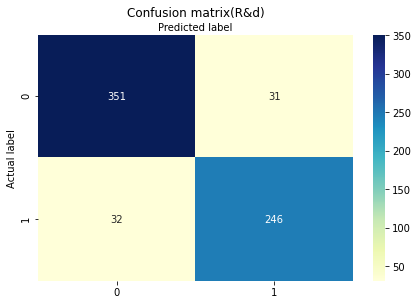

In [210]:
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_RD), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix(R&d)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

3.Check evaluation Metrics

In [230]:
#Look at the True Postive and True Negative:
TP = 246
TN = 351

# Look at the False Postive and False Negative

FP = 31
FN = 32

In [231]:
#3.Evaluation Metrics

print("Accuracy:",metrics.accuracy_score(test_labels_RD, y_pred_RD))
print("Precision:",metrics.precision_score(test_labels_RD, y_pred_RD))
print("Recall:",metrics.recall_score(test_labels_RD, y_pred_RD))
print("Specificity:", TN/(TN+FP))

Accuracy: 0.9045454545454545
Precision: 0.8848920863309353
Recall: 0.8880866425992779
Specificity: 0.918848167539267


#Interpretation of the confusion matrix
**(HIGH_INNOVATION) :**

The DistilBERT model has succesfully predicted 286 innovative companies that have R&D spending and 286 non-innovative companies that have 0 R&D spending based on the business descriptions. And the model fails to identify the other 32 innovative companies, and wrongly classified 31 non-innovative companies to the "innovative" group(HIGH_INNOVATION).

===========================================================================

Overall, the DistilBERT model performs very well. During our evaluation with the test data, the model correctly predict whether the company is a innovative company" 90% of the time. 

*  (Precision):
Besides, the model correctly predicted 85% of the innovative companies out of all the predictive "HIGH_INNOVATIVE"(innovative companies) classes.

*  (Recall)
The model correctly identified 82% of the innovative companies out of all the true innovative companies with R&D spending greater than zero.

*  (Specificity)
The model correctly identified 92% of the non-innovative companies out of all the true non-innovative companies with zero R&D spending.

Thus, the model seems to perform quite well for identifying whether a company is an innovative company, espcially when it is used to find out those non-innovative companies.



#Correlation

**Analyze the correlation between predicted value of "HIGH_ARR" and the predicted value of"HIGH_INNOVATION".**

Putting the predicted value back to the dataframe

In [212]:
y_pred_arr= lr_clf.predict(features_both)
y_pred_rd= clf.predict(features_both)

In [213]:
df_des['pred_arr']=y_pred_arr
df_des['pred_rd']=y_pred_rd

In [214]:
df_des.head()

,tic,sale,xrd,RD_intensity,HIGH_INNOVATION,ticker,Total Assets,Total Revenue,description,ar_ratio,HIGH_ARR,pred_arr,pred_rd
0,AAL,17337.000,0.0,0.000000,0,AAL,6.200800e+10,1.733700e+10,"American Airlines Group Inc., through its subs...",3.576628,1,1,0
1,CECE,316.011,0.0,0.000000,0,CECE,4.193140e+08,3.160110e+08,CECO Environmental Corp. provides industrial a...,1.326897,0,0,1
2,PNW,3586.982,0.0,0.000000,0,PNW,2.002042e+10,3.586982e+09,"Pinnacle West Capital Corporation, through its...",5.581411,1,1,0
3,PRG,2484.595,0.0,0.000000,0,PRG,1.317404e+09,2.484595e+09,"PROG Holdings, Inc. operates as an omnichannel...",0.530229,0,0,0
4,ABT,34608.000,2420.0,0.069926,1,ABT,7.254800e+10,3.460800e+10,"Abbott Laboratories discovers, develops, manuf...",2.096278,0,0,1


In [229]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df_des.pred_arr, df_des.pred_rd)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.281



***To be more specific, we zoom in only the predcitions for the test features, and examine the correlation between "HIGH_ARR"and " HIGH INNOVATION". ***

Given that test features are the same for the models, we can analyze the correlations between the predicted values for the same companies(with the same TICKERS).

In [216]:
y_pred_arr_test= lr_clf.predict(test_features_both)
y_pred_rd_test= clf.predict(test_features_both)

In [217]:
corr, _ = pearsonr(y_pred_arr_test, y_pred_rd_test)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.311


#Interpretatation of the correlation:

There seems to be a negative correlation between the predicted value of "HIGH_INNOVATION" and the predicted value of "HIGH_ARR". Judging from the business descriptions, the distilBERT model results may show us a correlation that innovative type of companies are on average less likely to be "high-asset intensity" companies, compared to those non-innovatie companies. 

Save the output as pdf